In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def grayscale(img):
    grayscaled = np.mean(img, axis=2)

    return grayscaled

In [3]:
def gaussian_kernel(l=5, sig=1.0):
    ax = np.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

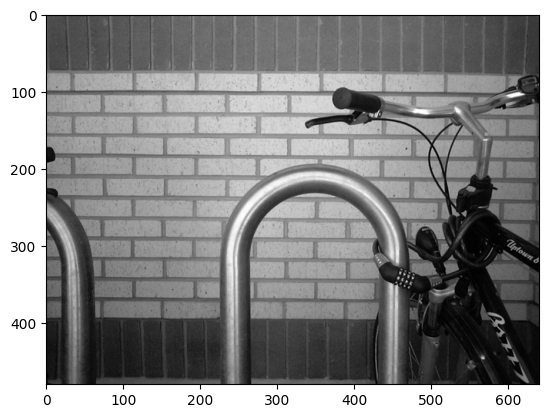

In [4]:
img = cv2.imread('imgs/image.jpg')

plt.imshow(img)

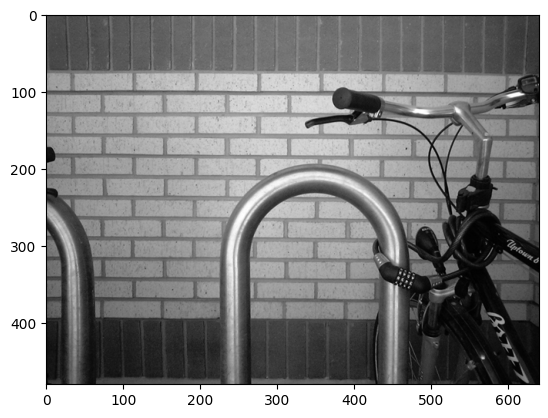

In [5]:
grayscaled = grayscale(img)
plt.imshow(grayscaled, cmap='gray')

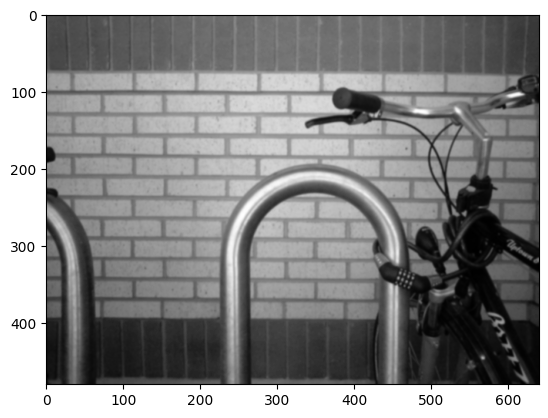

In [6]:
gaussian = gaussian_kernel(7, 1.0)
gaussed = cv2.filter2D(grayscaled, ddepth=-1, kernel=gaussian)

plt.imshow(gaussed, cmap='gray')

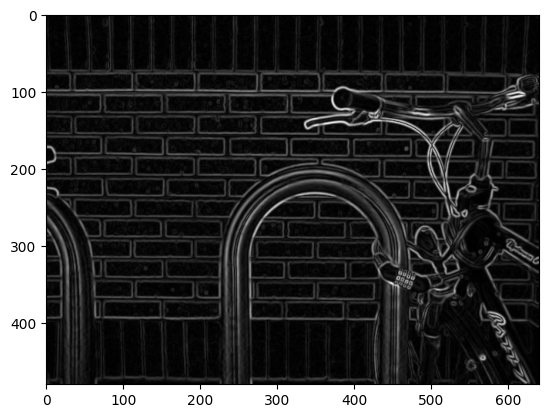

In [7]:
sobel_1 = np.array([[-1, -2, -1], 
                    [0, 0, 0],
                    [1, 2, 1]])
sobel_2 = np.transpose(sobel_1)

grad_x = cv2.filter2D(gaussed, ddepth=-1, kernel=sobel_1)
grad_y = cv2.filter2D(gaussed, ddepth=-1, kernel=sobel_2)

grads = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))
angles = np.arctan2(grad_y, grad_x)

plt.imshow(grads, cmap='gray')

In [8]:
from math import pi

def angle_approx(grad) :
    approx = np.zeros(grad.shape)
    for i in range(1, int(grad.shape[0] - 1)) :
        for j in range(1, int(grad.shape[1] - 1)) :
            
            if((grad[i, j] > -pi/8 and grad[i, j] <= pi/8) or (grad[i, j] <= -7*pi/8 and grad[i, j] > 7*pi/8)) :
                approx[i, j] = 0
                
            elif((grad[i, j] > pi/8 and grad[i, j] <= 3*pi/8) or (grad[i, j] <= -5*pi/8 and grad[i, j] > -7*pi/8)) :
                approx[i, j] = pi/4
                
            elif((grad[i, j] > 3*pi/8 and grad[i, j] <= 5*pi/8) or (grad[i, j] <= -3*pi/8 and grad[i, j] > -5*pi/8)) : 
                approx[i, j] = pi/2
                
            else:
                approx[i, j] = 3*pi/4
                
    return approx


In [10]:
def nms(grad, angles) :
    sharped = np.zeros(grad.shape)
    for i in range(1, int(grad.shape[0] - 1)):
        for j in range(1, int(grad.shape[1] - 1)):
            
            if(angles[i, j] == 0) :
                if((grad[i, j] > grad[i, j+1]) and (grad[i, j] > grad[i, j-1])):
                    sharped[i, j] = grad[i, j]
                else:
                    sharped[i, j] = 0
            
            elif(angles[i, j] == pi/4) :
                if((grad[i, j] > grad[i+1, j+1]) and (grad[i, j] > grad[i-1, j-1])):
                    sharped[i, j] = grad[i, j]
                else:
                    sharped[i, j] = 0
            
            elif(angles[i, j] == pi/2) :
                if((grad[i, j] > grad[i+1, j]) and (grad[i, j] > grad[i-1, j])):
                    sharped[i, j] = grad[i, j]
                else:
                    sharped[i, j] = 0
            
            elif(angles[i, j] == 3*pi/4):
                if((grad[i, j] > grad[i+1, j-1]) and (grad[i, j] > grad[i-1, j+1])):
                    sharped[i, j] = grad[i, j]
                else:
                    sharped[i, j] = 0
            
    return sharped/np.max(sharped) * 255

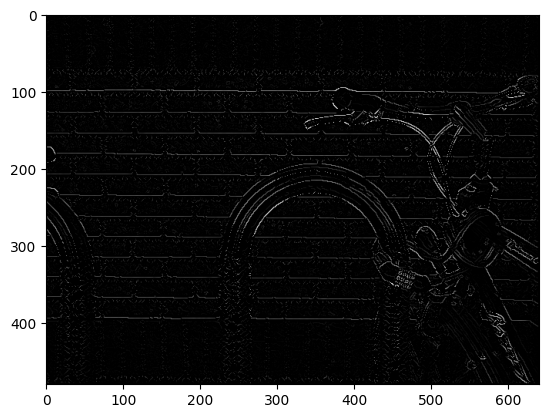

In [11]:
approx = angle_approx(angles)
sharp = nms(grads, approx)

plt.imshow(sharp, cmap='gray')

In [24]:
def blob_analysis(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                

def thresholding(img, low_ratio, high_ratio):
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)

    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            else :
                temp_img[i, j] = 1
    
    total_strong = np.sum(temp_img == 2)
    while True:
        blob_analysis(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    

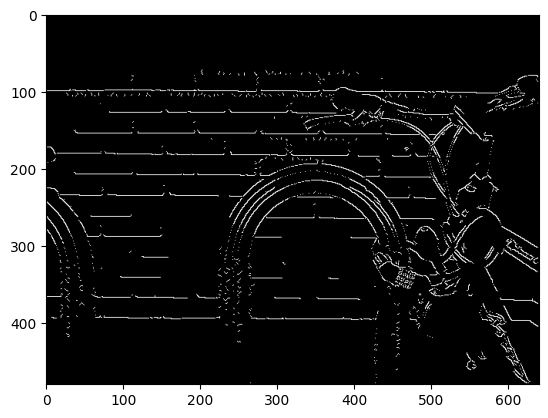

In [27]:
final = thresholding(sharp, 0.1, 0.3)

plt.imshow(final, cmap='gray')